In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tp3

In [12]:
def crear_matriz(anchor_dict):
    rows = []
    bs = []
    for key,value in anchor_dict.items():
        xi,yi = value["pos"]
        theta = value["angulo"]

        t = np.tan(theta)

        rows.append([1.0,-t])
        bs.append(xi - t * yi)
    
    return np.array(rows), np.array(bs)

In [13]:
def ls(A,b):
    # Uso este método para una mayor estabilidad numérica
    sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    return sol

def plot_results(ax, anchors, p_true, p_est = None, title = None):
    xs = []
    ys = []

    for k, v in anchors.items():
        xi,yi = v["pos"]
        xs.append(xi)
        ys.append(yi)
    ax.plot(xs, ys,'o', label = "Anclas")
    ax.plot(p_true[0], p_true[1], 'o', label = "Posición real", markersize=10)

    if p_est is not None:
        ax.plot(p_est[0], p_est[1], 'x', label = "Posición estimada", markersize=15)
    
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    if title: ax.set_title(title)
    ax.legend()

Inciso A)

In [14]:
p_true = np.array(tp3.p)
config_1 = tp3.config_1

Ejercicio 2(a)
Posición real: [100  50]
Estimación sin ruido: [100.  50.]


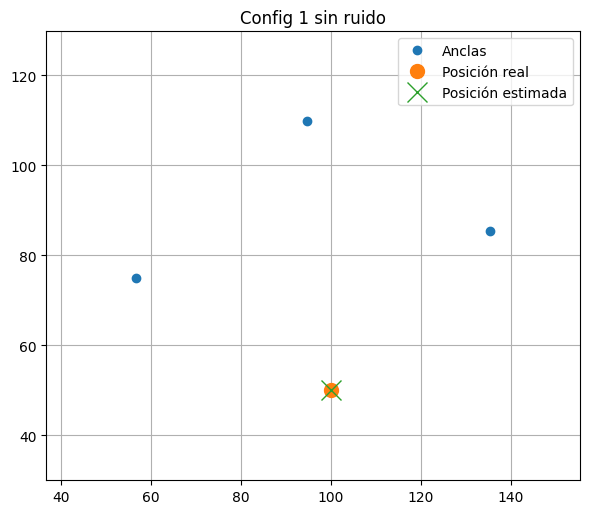

In [15]:
A1, b1 = crear_matriz(config_1)
p_hat1 = ls(A1,b1)

print("Ejercicio 2(a)")
print("Posición real:", p_true)
print("Estimación sin ruido:", p_hat1)

# Por un tema de escalada de gráficos para una mejor visualización
all_x = [p_true[0]] + [v["pos"][0] for v in config_1.values()]
all_y = [p_true[1]] + [v["pos"][1] for v in config_1.values()]
xmin, xmax = min(all_x)-20, max(all_x)+20
ymin, ymax = min(all_y)-20, max(all_y)+20

fig, ax = plt.subplots(figsize=(6,6))
plot_results(ax, config_1, p_true, p_hat1,"Config 1 sin ruido")
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.show()

Inciso B)

In [16]:
def simular_ruido(anchors, sigma2, n_real = 50):
    sigma = np.sqrt(sigma2)
    ests = np.zeros((n_real,2))
    keys = list(anchors.keys())
    for i in range(n_real):
        noisy = {}
        for k in keys:
            xi,yi = anchors[k]["pos"]
            theta = anchors[k]["angulo"]
            dx = np.random.normal(0,sigma)
            dy = np.random.normal(0,sigma)
            noisy[k] = {"pos": (xi + dx, yi + dy), "angulo": theta}
        A, b = crear_matriz(noisy)
        ests[i,:] = ls(A,b)
    return ests

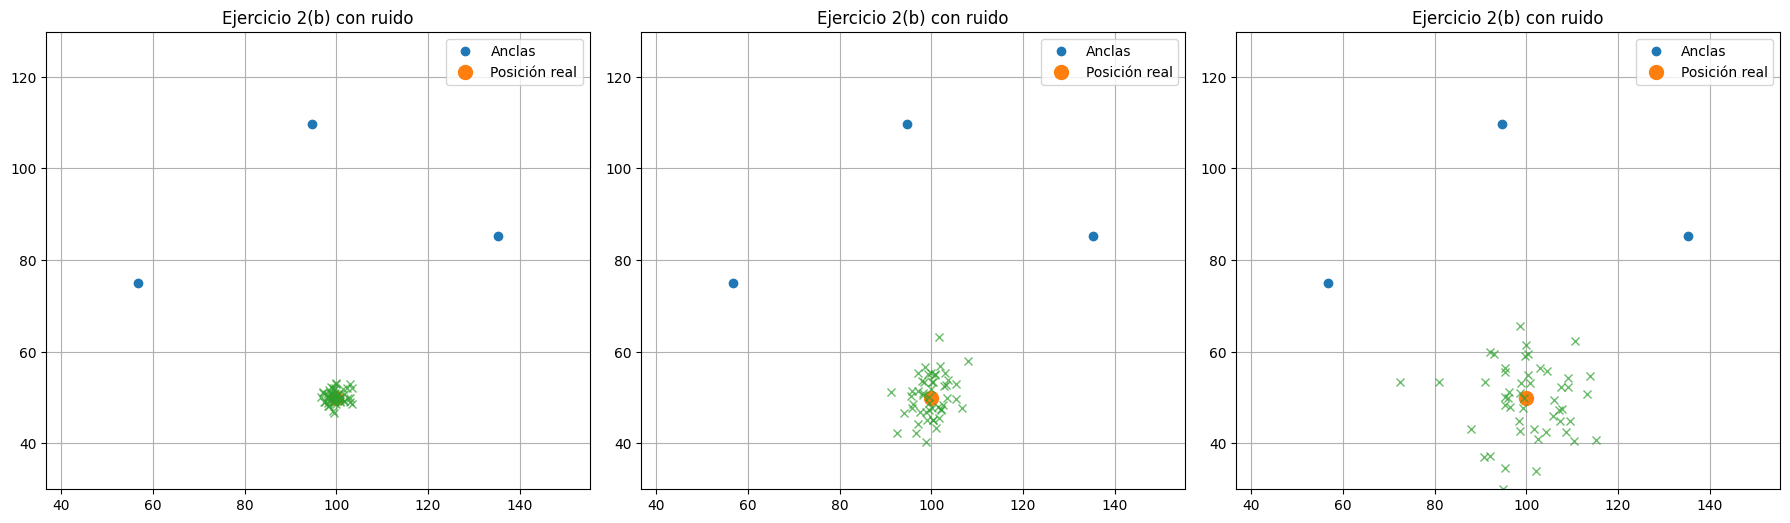

In [17]:
sigma2 = [4,25,100]
fig,axs = plt.subplots(1, 3, figsize=(18,6))

# Por un tema de escalada de gráficos para una mejor visualización
all_x = [p_true[0]] + [v["pos"][0] for v in config_1.values()]
all_y = [p_true[1]] + [v["pos"][1] for v in config_1.values()]
xmin, xmax = min(all_x)-20, max(all_x)+20
ymin, ymax = min(all_y)-20, max(all_y)+20

for ax, s2 in zip(axs, sigma2):
    ests = simular_ruido(config_1, s2, n_real = 50)
    plot_results(ax, config_1, p_true, None, title=f"Ejercicio 2(b) con ruido")
    ax.plot(ests[:,0], ests[:,1], 'x', alpha = 0.7)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.show()

Inciso C)

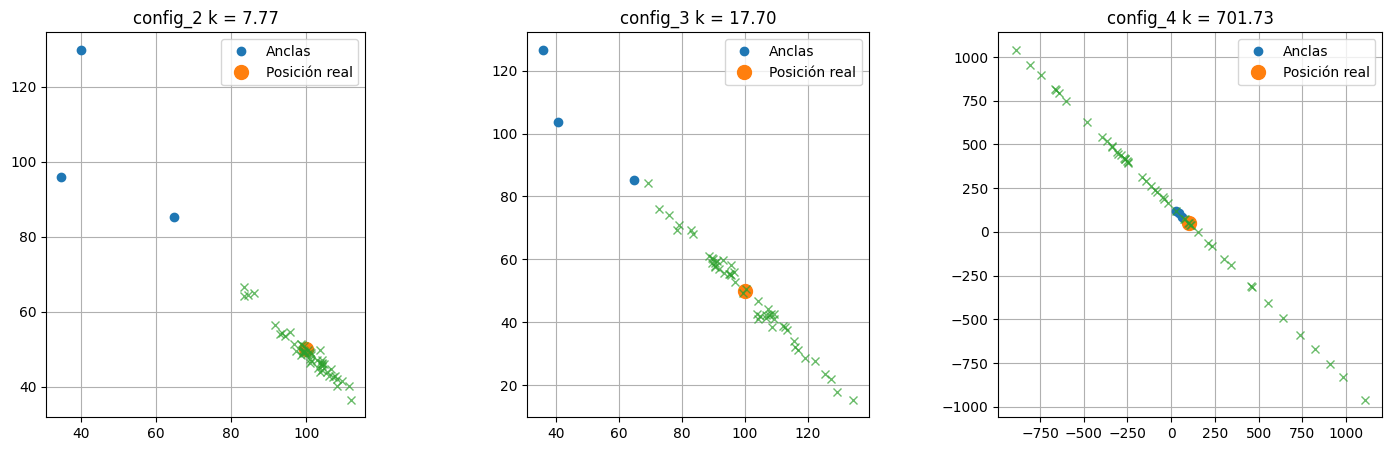

  config      kappa                                  mean_est                                  std_est
config_2   7.773725  [100.45600846602936, 48.851092641354924]  [6.493490043377469, 6.2177742768384805]
config_3  17.697740  [100.74408315371478, 48.943472722129975] [14.781314375531052, 15.299936084664953]
config_4 701.728419 [-31.429726223913296, 181.28383273429353]   [466.259034477796, 466.31367993906343]


In [18]:
sigma2 = 4
configs = {"config_2": tp3.config_2, "config_3": tp3.config_3, "config_4": tp3.config_4}

summary = []
fig, axs = plt.subplots(1, 3, figsize = (18,5))
for (name, cfg), ax in zip(configs.items(), axs):
    A, b = crear_matriz(cfg)
    kappa = np.linalg.cond(A)
    ests = simular_ruido(cfg, sigma2, n_real = 50)

    # Graficos
    plot_results(ax, cfg, p_true, None, title=f"{name} k = {kappa:.2f}")
    ax.plot(ests[:,0], ests[:,1], 'x', alpha = 0.7)

    # Estadísticas
    mean_est = ests.mean(axis = 0)
    std_est = ests.std(axis = 0)
    summary.append((name, kappa, mean_est, std_est))

plt.show()

df = pd.DataFrame(summary, columns=["config","kappa","mean_est","std_est"])
print(df.to_string(index=False))

### Experimento

In [19]:
import utm

def wgs84_to_utm(lat, lon):
    """
    Convierte coordenadas WGS84 (latitud, longitud) a UTM.
    Retorna: (Este, Norte, Zona, Letra)
    """
    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_number, zone_letter


def utm_to_wgs84(easting, northing, zone_number, zone_letter):
    """
    Convierte coordenadas UTM a WGS84 (latitud, longitud).
    Retorna: (lat, lon)
    """
    lat, lon = utm.to_latlon(easting, northing, zone_number, zone_letter)
    return lat, lon

# Coordenadas de Estatua
lat1 = 34.2647
lon1 = 58.3148

# Coordenadas de Triangulo Cafeteria
lat2 = 34.2647
lon2 = 58.3144

# Coordenadas Monsegur
lat3 = 34.2649
lon3 = 58.3142

# Convertir a UTM
e1, n1, *_ = wgs84_to_utm(lat1, lon1)
e2, n2, *_ = wgs84_to_utm(lat2, lon2)
e3, n3, *_ = wgs84_to_utm(lat3, lon3)

medicion = {
"P1":{"pos": (e1, n1),"angulo": -1.22173},
"P2":{"pos": (e2, n2),"angulo": 0.994838},
"P3":{"pos": (e3, n3),"angulo": 2.00713}
}

# Coordenadas nuestra posición
lat = 34.2647
lon = 58.3145
e, n, *_ = wgs84_to_utm(lat, lon)
p_nuestra = (e,n)

Ejercicio 3 (Experimento)
Posición real: (np.float64(621017.3182688074), np.float64(3792287.6903132712))
Estimación sin ruido: [ 621020.80570497 3792296.04477554]


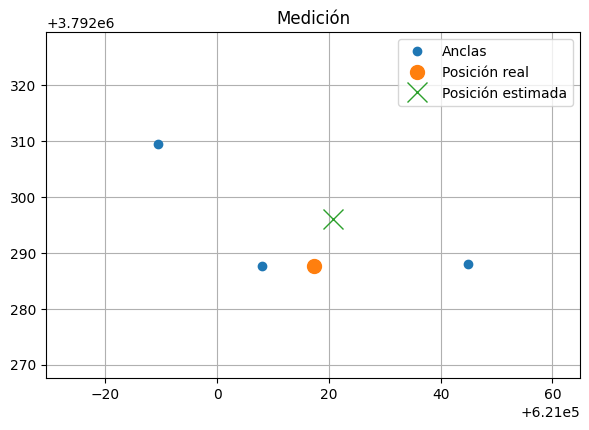

In [ ]:
Am, bm = crear_matriz(medicion)
p_m = ls(Am,bm)

print("Ejercicio 3 (Experimento)")
print("Posición real:", p_nuestra)
print("Estimación:", p_m)

# Por un tema de escalada de gráficos para una mejor visualización
all_x = [p_nuestra[0]] + [v["pos"][0] for v in medicion.values()]
all_y = [p_nuestra[1]] + [v["pos"][1] for v in medicion.values()]
xmin, xmax = min(all_x)-20, max(all_x)+20
ymin, ymax = min(all_y)-20, max(all_y)+20

fig, ax = plt.subplots(figsize=(6,6))
plot_results(ax, medicion, p_nuestra, p_m,"Medición")
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.show()